** Porto Seguro’s Safe Driver Prediction **  

Solomon Gebreyohannes  
Udacity Machine Learning Engineer Nanodegree Capstone Project  
December, 2017  

[Source: The challenge and data are taken from Kaggle competition: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction]  

** 1. Definition **

** 1.1 Project Overview ** 

** 1.2 Problem Statement ** 

** 1.3 Metrics ** 

**2. Analysis **

**2.1 Data Exploration** 

In [3]:
# Import ncecessary packages 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import csv 
%matplotlib inline

from sklearn import preprocessing 
from sklearn.preprocessing import Imputer 
from sklearn.decomposition import PCA 
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV 
from sklearn import model_selection  

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.linear_model import LogisticRegression 

In [3]:
# Import training, testing, and sample submission data
train  = pd.read_csv('data/train.csv'); 
test   = pd.read_csv('data/test.csv'); 
sample = pd.read_csv('data/sample_submission.csv') 

In [4]:
# Training and testing data size 
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [5]:
# Sample training and testing data sets 
print("Training data sample ... \n",train.head())
print("Testing data sample ... \n",test.head())

Training data sample ... 
    id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin       ...        \
0              0              0              1              0       ...         
1              0              0              0              1       ...         
2              0              0              0              1       ...         
3              0              1              0              0       ...         
4              0              1              0              0       ...         

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0 

In [6]:
# Number of "claims" and "non-claims" 
target = train['target'] 
print(target.value_counts())

0    573518
1     21694
Name: target, dtype: int64


In [7]:
# Number of rows without any missing value (of any feature)  
temp_train = pd.read_csv('data/train.csv',na_values='-1'); 
temp_test  = pd.read_csv('data/test.csv',na_values='-1'); 
temp_train = temp_train.dropna(axis=0, how='any') 
temp_test  = temp_test.dropna(axis=0, how='any') 

print(temp_train.shape) 
print(temp_test.shape)

(124931, 59)
(186567, 58)


**2.2 Exploratory Visualization**

** Categorical features **

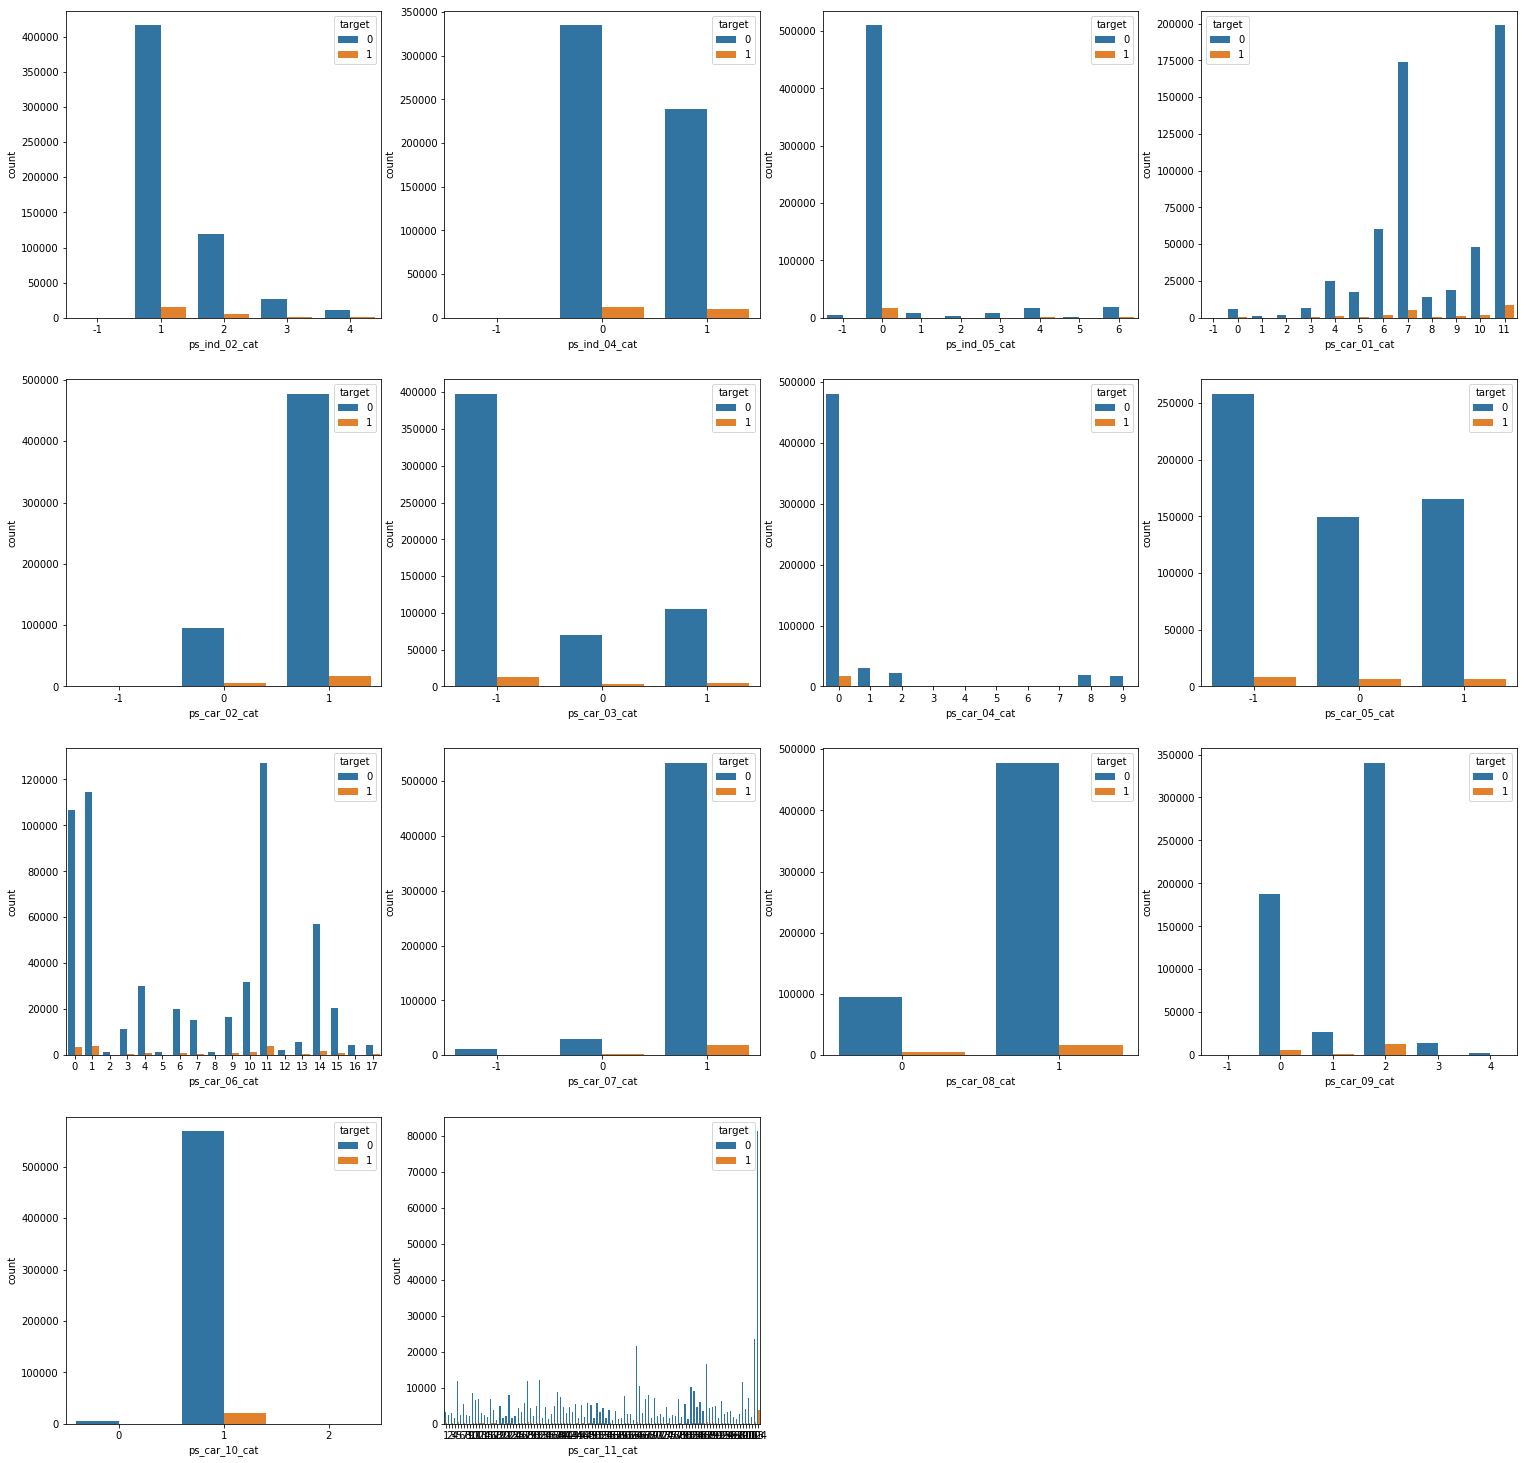

In [8]:
# Categorical feature labels  
cat_labels = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat',
              'ps_car_03_cat','ps_car_04_cat','ps_car_05_cat','ps_car_06_cat','ps_car_07_cat',
              'ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat'] 

# Visualization 
fig = plt.figure(figsize=(26,26)) 

for i in range(4): 
    for j in range(4): 
        if (4*i+j < 14):    # 14 categorical features 
            ax = plt.subplot2grid((4,4),(i,j),colspan=1)  
            ax = sns.countplot(x=cat_labels[4*i+j],hue='target',data=train,ax=ax) 

# Save the categorical features figure 
fig.savefig('categorical_features.png')

** Continuous features ** 

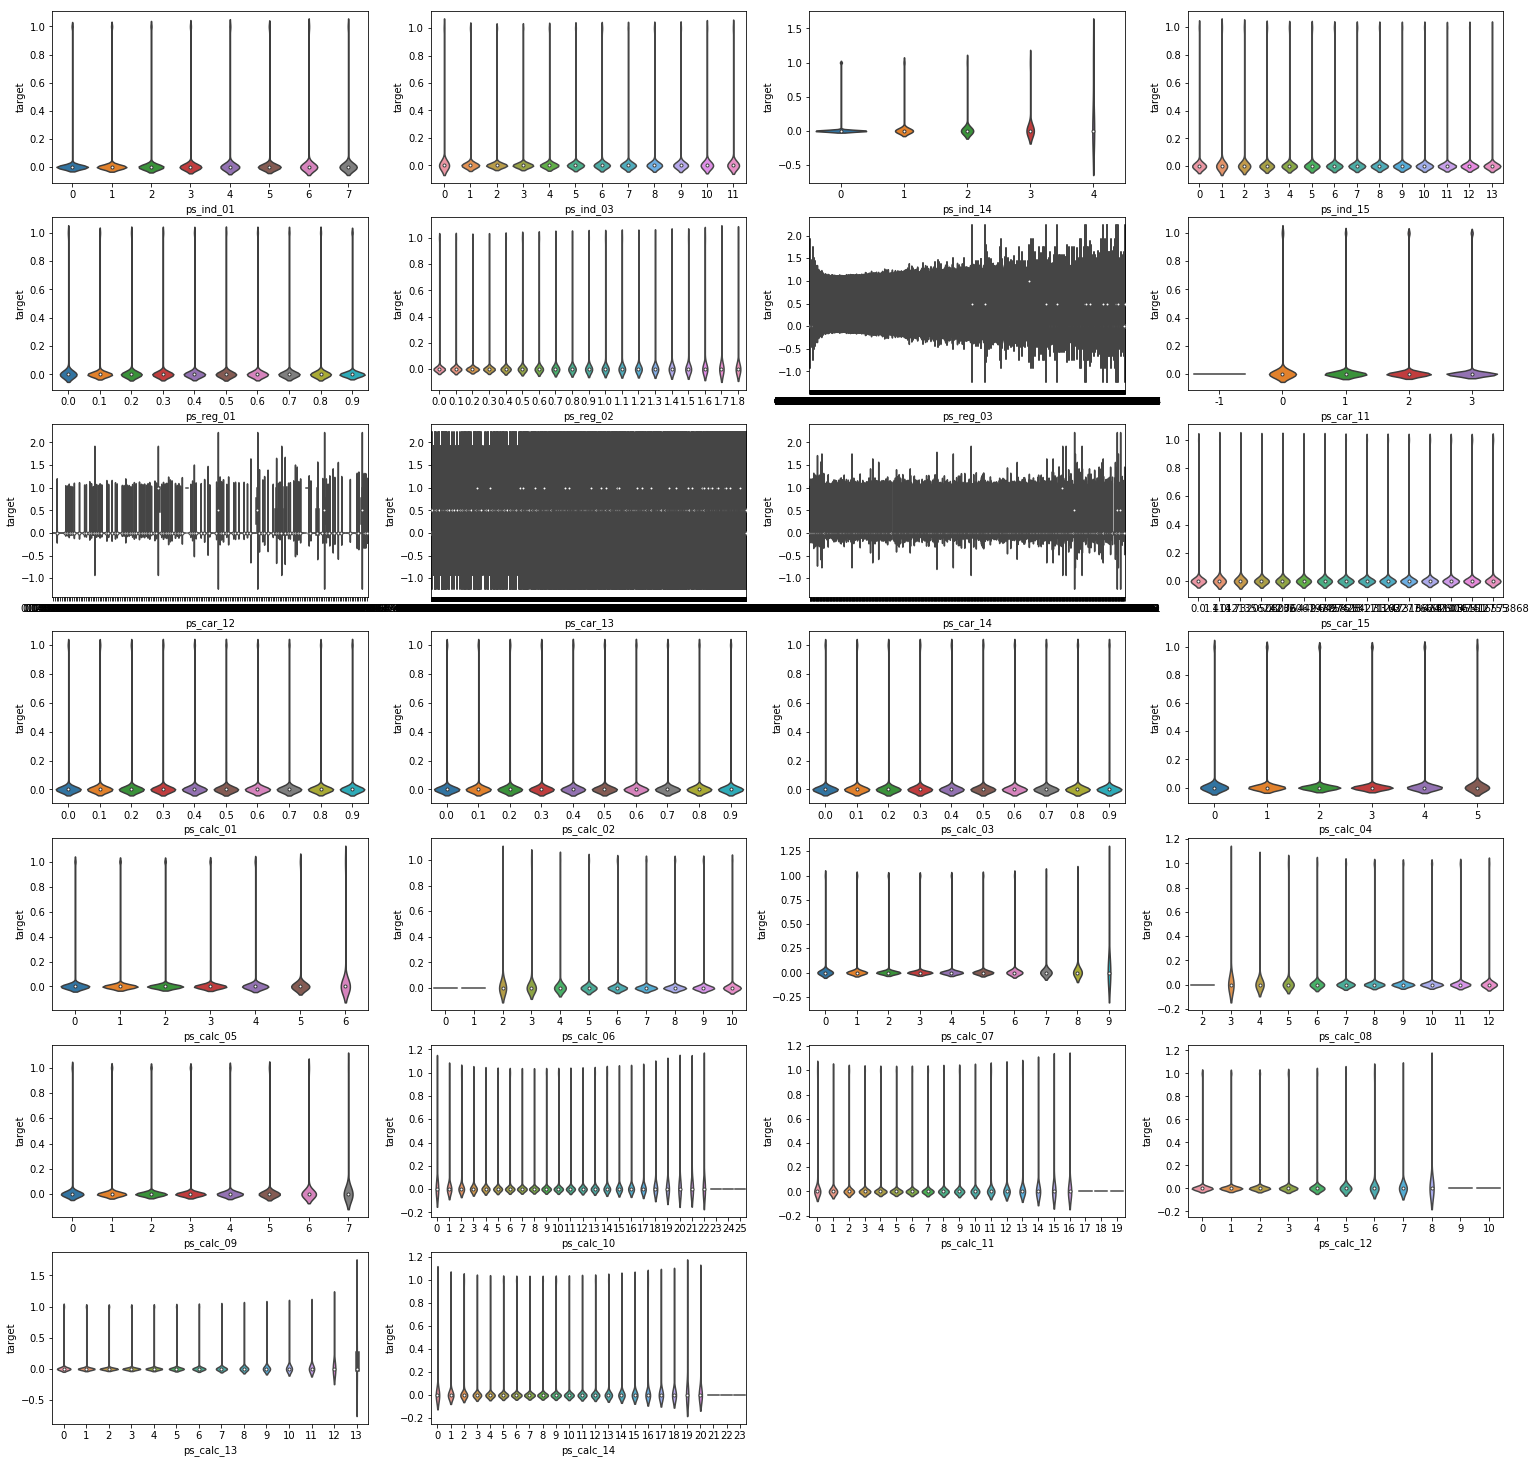

In [9]:
# Continuous feature labels  
cnt_labels = ['ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15', 'ps_reg_01',
              'ps_reg_02','ps_reg_03', 'ps_car_11','ps_car_12','ps_car_13', 
              'ps_car_14','ps_car_15', 'ps_calc_01','ps_calc_02','ps_calc_03',
              'ps_calc_04','ps_calc_05','ps_calc_06','ps_calc_07','ps_calc_08',
              'ps_calc_09','ps_calc_10','ps_calc_11','ps_calc_12','ps_calc_13',
              'ps_calc_14'] 

# cnt_labels = ['ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15', 'ps_reg_01',
#               'ps_reg_02','ps_reg_03', 'ps_car_11','ps_car_12','ps_car_13', 
#               'ps_car_14','ps_car_15']

train_cnt = train[cnt_labels] 

# Visualization: violin plots  
fig = plt.figure(figsize=(26,26)) 

for i in range(7): 
    for j in range(4): 
        if (4*i+j < 26):    # 26 continuous features 
            ax = plt.subplot2grid((7,4),(i,j),colspan=1)  
            ax = sns.violinplot(x=cnt_labels[4*i+j],y='target',data=train,ax=ax) 
            
# Save the continuous features figure 
fig.savefig('continuous_features_violinplot.png')  

In [4]:
# Continuous features without the features that start with "ps_calc" 
cnt_labels = ['ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15', 'ps_reg_01',
              'ps_reg_02','ps_reg_03', 'ps_car_11','ps_car_12','ps_car_13', 
              'ps_car_14','ps_car_15']

train_cnt = train[cnt_labels] 

** Binary features ** 

... 

** All the features **

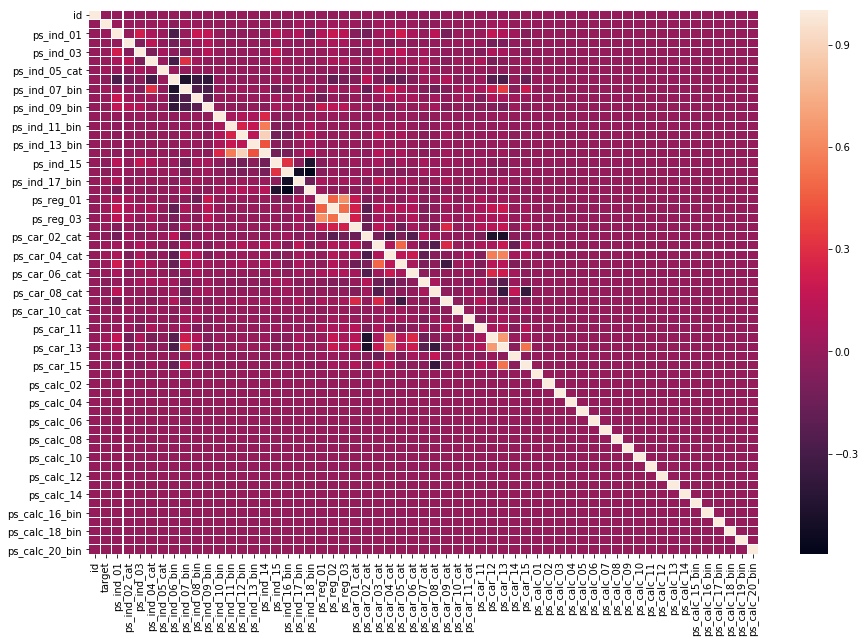

In [11]:
# Correlation of features 
fig = plt.figure(figsize=(15,10)) 
sns.heatmap(train.corr(),annot=False,linewidths=0.01) 

# Save the correlation of the features figure 
fig.savefig('features_correlation.png')

** 2.3 Algorithms and Techniques ** 

In [12]:
target = np.array(train['target']) 
print(len(target))

595212


** 2.4 Benchmark ** 

** 3. Methodology ** 

** 3.1 Data Preprocessing** 

** Flattening categorical features and binary features ** 

In [13]:
catbin_labels = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_03_cat', 
                 'ps_car_04_cat','ps_car_05_cat','ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat', 
                 'ps_car_10_cat','ps_car_11_cat','ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin', 
                 'ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin','ps_ind_16_bin','ps_ind_17_bin',
                 'ps_ind_18_bin'] 

train_catbin = train[catbin_labels] 
test_catbin  = test[catbin_labels] 

# Combine train and test data to do the same operation 
train_test_catbin = [train_catbin, test_catbin] 
train_test_catbin = pd.concat(train_test_catbin) 

# Change to binary including the missing values, which are indicated as -1 
print(train_test_catbin.shape) 
train_test_catbin = pd.get_dummies(train_test_catbin,columns=catbin_labels) 
print(train_test_catbin.shape)  

(1488028, 25)
(1488028, 206)


In [14]:
# Remove missing values columns, '-1' columns  
train_test_catbin = train_test_catbin.drop(['ps_ind_02_cat_-1','ps_ind_04_cat_-1','ps_ind_05_cat_-1','ps_car_01_cat_-1',
                                            'ps_car_02_cat_-1','ps_car_03_cat_-1','ps_car_05_cat_-1','ps_car_07_cat_-1',
                                            'ps_car_09_cat_-1'], axis=1) 
print(train_test_catbin.shape) 

(1488028, 197)


** Continuous features ** 

Missing values 

In [15]:
# Replace missed values with the mean 
imp = Imputer(missing_values=-1,strategy='mean',axis=0)

# On training data 
imp.fit(train_cnt)
train_cnt = imp.transform(train_cnt) 
print(train_cnt.shape) 

# On testing data 
test_cnt = test[cnt_labels] 
imp.fit(test_cnt)
test_cnt = imp.transform(test_cnt) 
print(test_cnt.shape) 

(595212, 12)
(892816, 12)


Scaling 

In [16]:
min_max_scaler = preprocessing.MinMaxScaler()
# On training data  
min_max_scaler.fit(train_cnt)
train_cnt = min_max_scaler.transform(train_cnt) 
print(train_cnt.shape) 

# On testing data 
min_max_scaler.fit(test_cnt)
test_cnt = min_max_scaler.transform(test_cnt)
print(test_cnt.shape)

(595212, 12)
(892816, 12)


** Combine the categorical, binary, and continuous features **

In [17]:
# Change dataframes to numpy arrays 
train_test_catbin = np.array(train_test_catbin)
train_catbin = train_test_catbin[:595212][:] 
test_catbin  = train_test_catbin[595212:][:] 

train_cnt = np.array(train_cnt)
test_cnt = np.array(test_cnt) 

# Combine all features 
train_data = np.concatenate((train_cnt, train_catbin),axis=1) 
test_data  = np.concatenate((test_cnt, test_catbin),axis=1) 

print(train_data.shape)   
print(test_data.shape)   

(595212, 209)
(892816, 209)


PCA

In [18]:
# Dimension reduction using PCA 
pca = PCA(n_components=50) 

# On testing
pca.fit(train_data)  
train_data_pca = pca.transform(train_data) 
print(train_data_pca.shape) 
print(train_data.shape) 

# On training 
pca.fit(test_data) 
test_data_pca = pca.transform(test_data) 
print(test_data_pca.shape) 
print(test_data.shape)

(595212, 50)
(595212, 209)
(892816, 50)
(892816, 209)


** 3.2 Implementation ** 

In [19]:
# Score 
"""
Source: https://www.kaggle.com/johannesss/stacking-lightgbm-with-logisticregression 
""" 

def gini(y_true, y_prob):
    """
    Original author CPMP : https://www.kaggle.com/cpmpml
    In kernel : https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini    

def gini_normalized(a, p):
     return gini(a, p) / gini(a, a) 

** 3.2.1 Random Forest **  

In [24]:
# Random forest 
# With PCA 
clf_randomforest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, random_state=0) 
clf_randomforest.fit(train_data_pca, target)
target_predict_randomforest = clf_randomforest.predict_log_proba(test_data_pca)

# Save output 
sample = pd.read_csv('data/sample_submission.csv',low_memory=False)  
sample.target = -1.0*target_predict_randomforest 
sample.to_csv("benchmark_randomforest.csv", float_format='%.6f',index=False) 

The score is 0.23422 (private score) and 0.22379 (public score). 

** 3.2.2 Extreme Gradient boosting classifier ** 

In [26]:
# With PCA 
clf = xgb.XGBClassifier()
clf.fit(train_data_pca, target, eval_metric=gini_normalized) 
target_predict = clf.predict_proba(test_data_pca)  

# Save output 
sample = pd.read_csv('data/sample_submission.csv',low_memory=False)  
sample.target = 1.0-target_predict
sample.to_csv("xgboost_pca.csv", float_format='%.6f',index=False) 

The score is 0.24930 (private score) and 0.24227 (public score).  
Improvement (from benchmark) is 6.44% (private score) and 8.26% (public score).  

** 3.3 Refinement **

** 3.3.1 No PCA ** 

In [27]:
# Without PCA 
clf = xgb.XGBClassifier()
clf.fit(train_data, target, eval_metric=gini_normalized) 
target_predict = clf.predict_proba(test_data)  

# Save output 
sample = pd.read_csv('data/sample_submission.csv',low_memory=False)  
sample.target = 1.0-target_predict
sample.to_csv("xgb_nopca.csv", float_format='%.6f',index=False) 

The score is 0.27345 (private score) and 0.26842 (public score).   
Improvement (from PCA) is 9.67% (private score) and 10.79% (public score).  

** 3.3.2 Without "ps_calc" input features **                    

The score is 0.27385 (private score) and 0.26915 (public score).   
Improvement (from all features) is 0.15% (private score) and 0.27%. 

** 3.3.3 Grid search ** 

In [ ]:
# xgboost 
xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100], 
              'missing':[-999],
              'seed': [1337]}

clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(target, n_folds=5, shuffle=True), 
                   scoring=gini_normalized,
                   verbose=2, refit=True) 

clf.fit(train_data, target) 

target_predict = clf.predict_proba(test_data)  

sample.target = 1.0-target_predict
sample.to_csv("xgboost_gridsearch.csv", float_format='%.6f',index=False) 

# plot feature importance 
fig = plt.figure(figsize=(26,26)) 
plot_importance(clf) 
plt.show() 
# Save the continuous features figure 
fig.savefig('feature_selection.png')  

Fitting 5 folds for each of 1 candidates, totalling 5 fits


The score is ... 

Gridsearch over xgboost parameters is taking too long. 

In [28]:
n_splits = 3  
num_models = 3 

splitter = model_selection.StratifiedShuffleSplit(n_splits=n_splits)

X_train = pd.DataFrame(train_data)  
y_train = target 
X_test  = pd.DataFrame(test_data) 

model1 = xgb.XGBClassifier() 
model2 = xgb.XGBClassifier(n_estimators=125) 
model3 = xgb.XGBClassifier(n_estimators=150)

X_logreg_train  = np.zeros((X_train.shape[0], n_splits*num_models))
X_logreg_test   = np.zeros((X_test.shape[0], n_splits*num_models)) 

{'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 125, 'nthread': -1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 150, 'nthread': -1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 

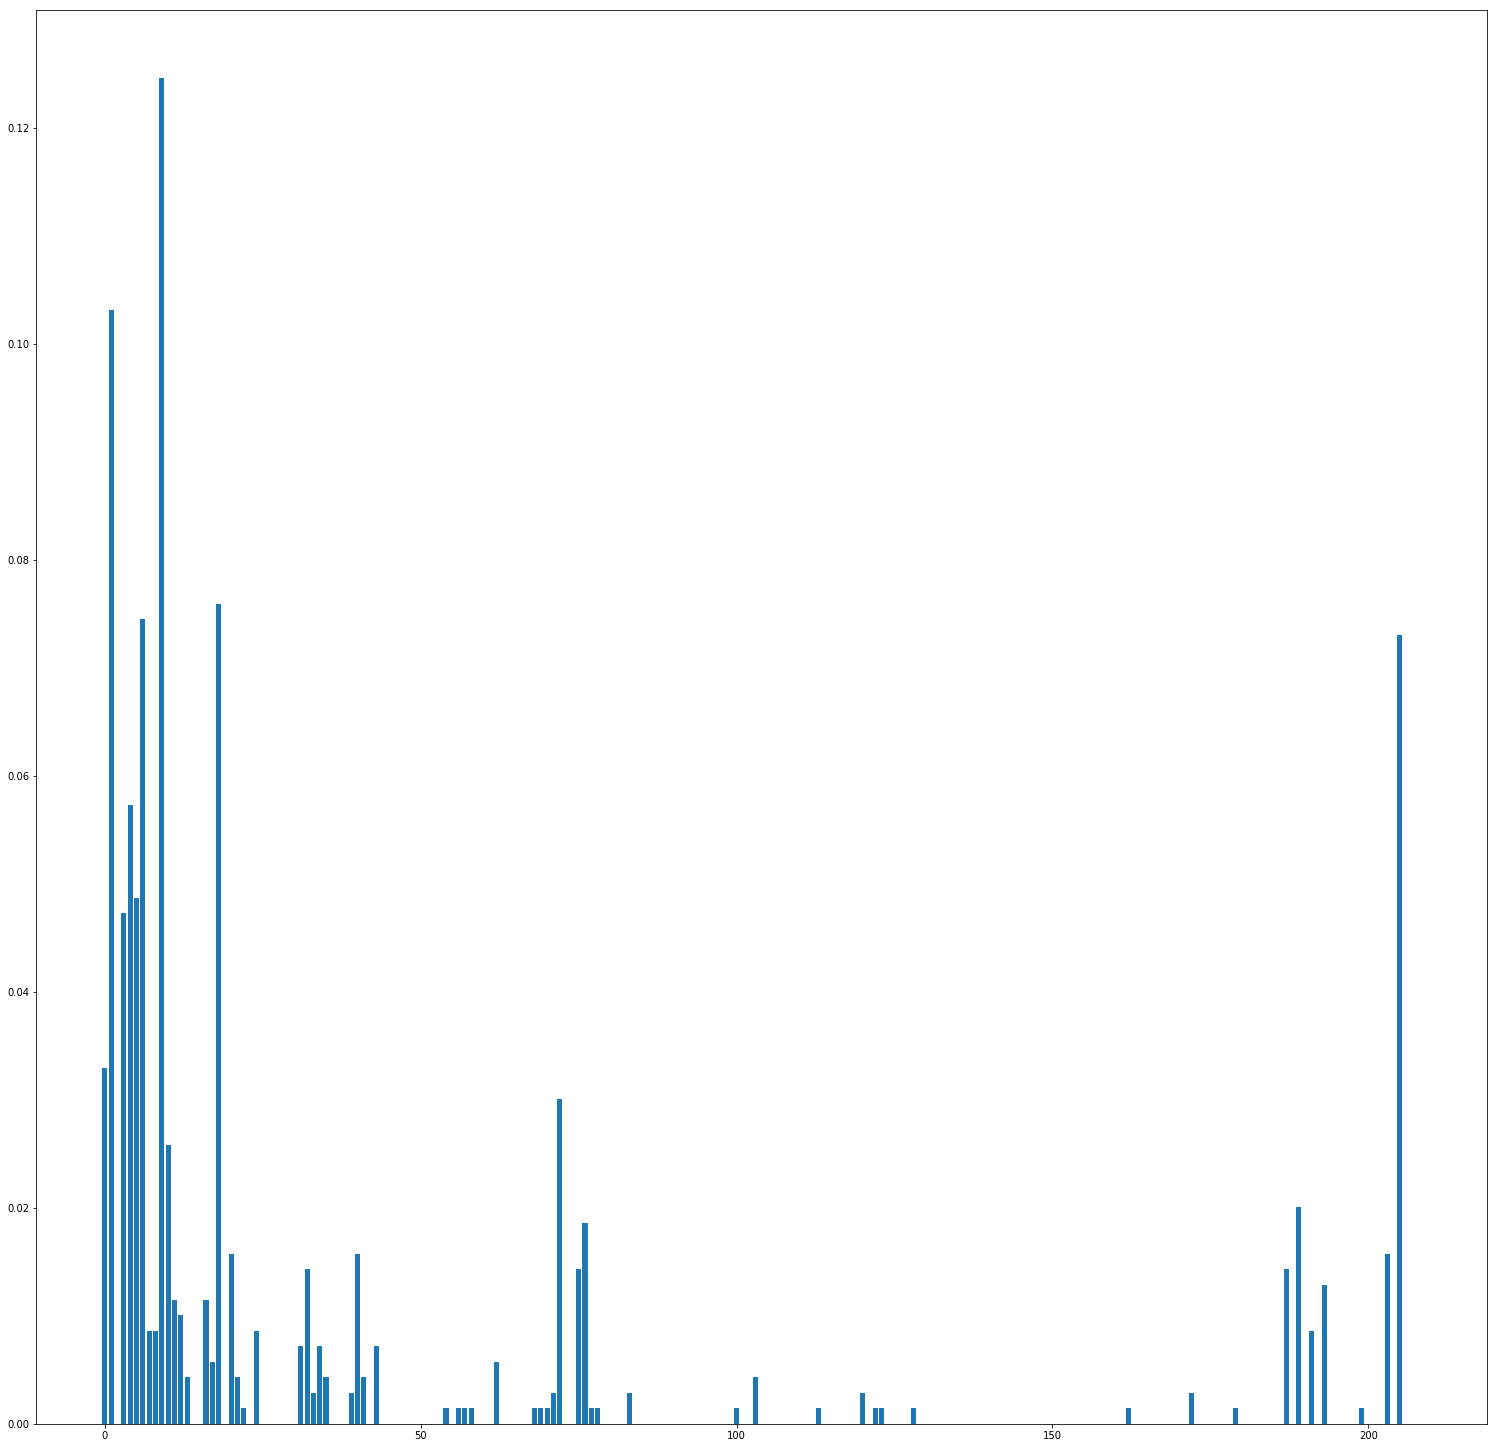

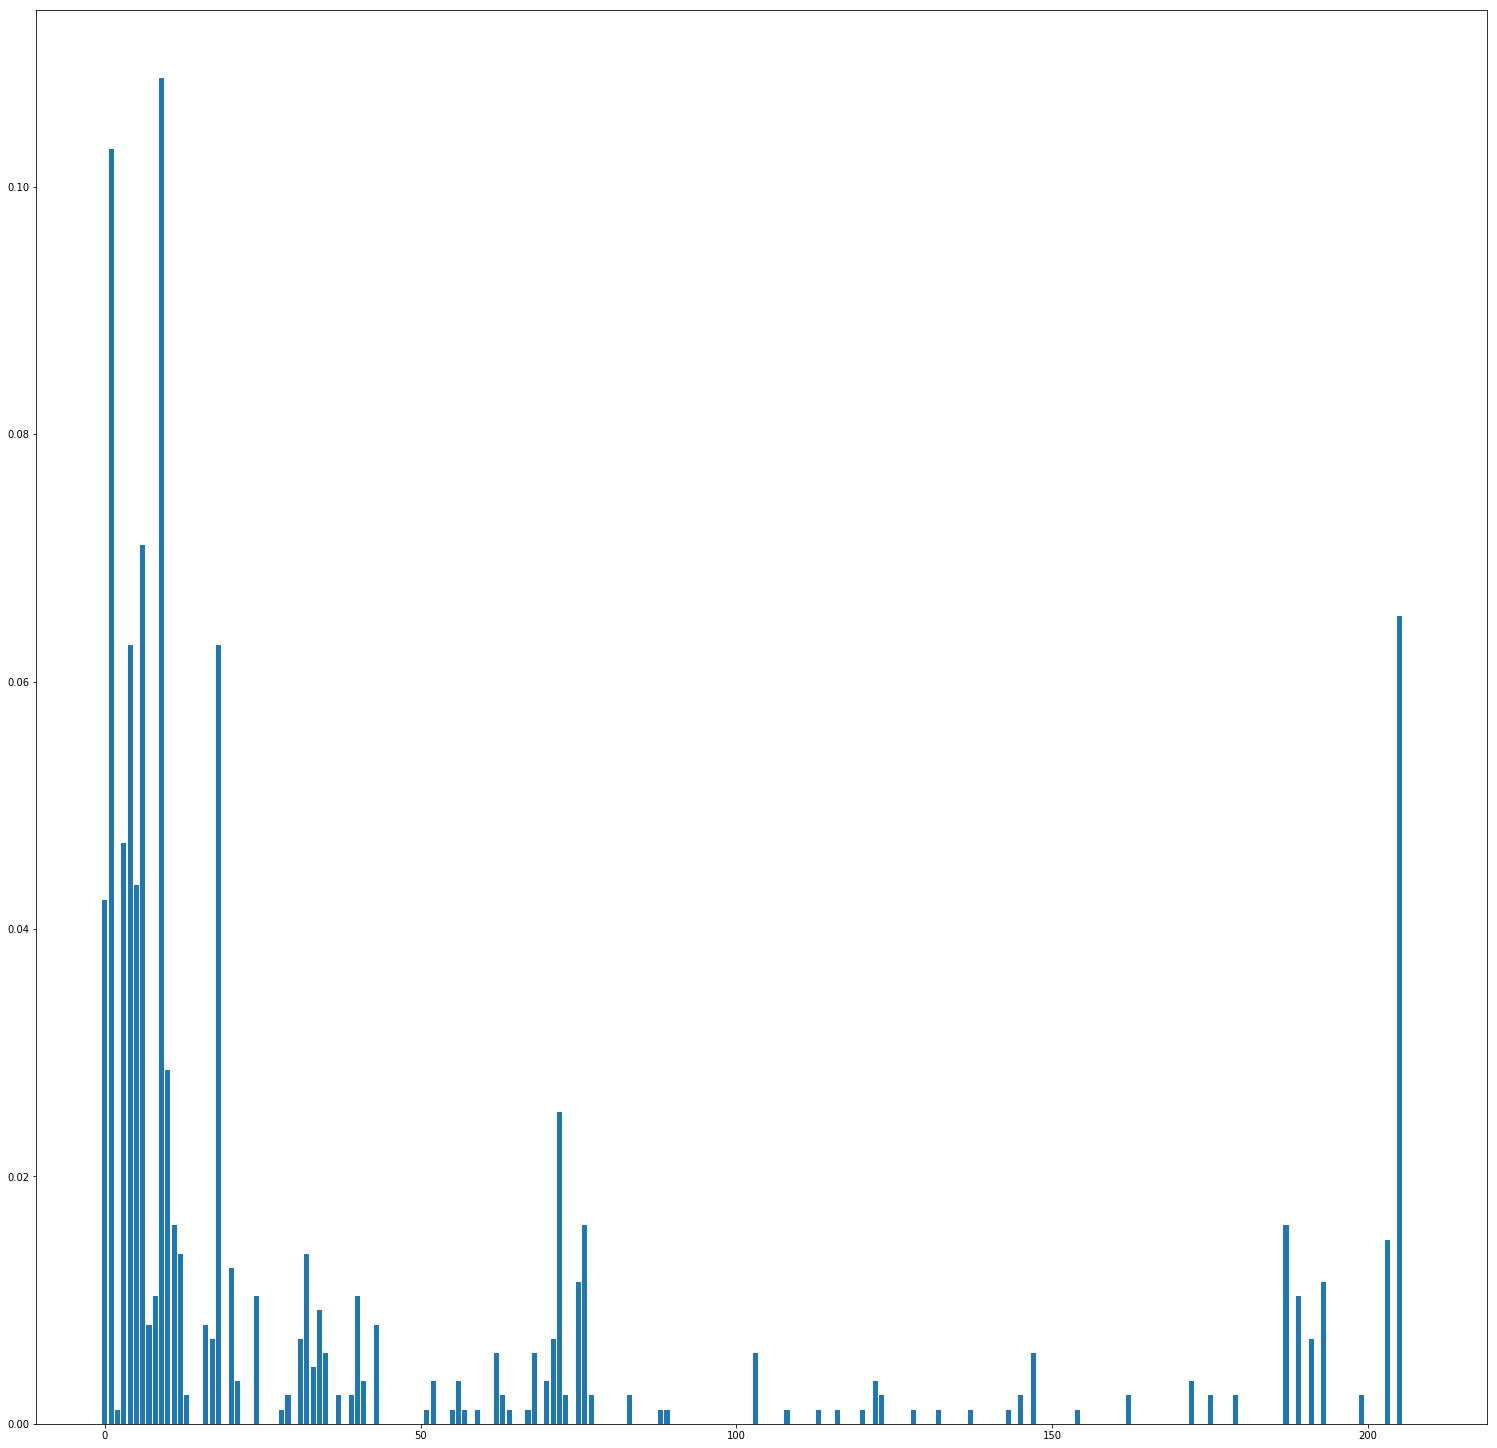

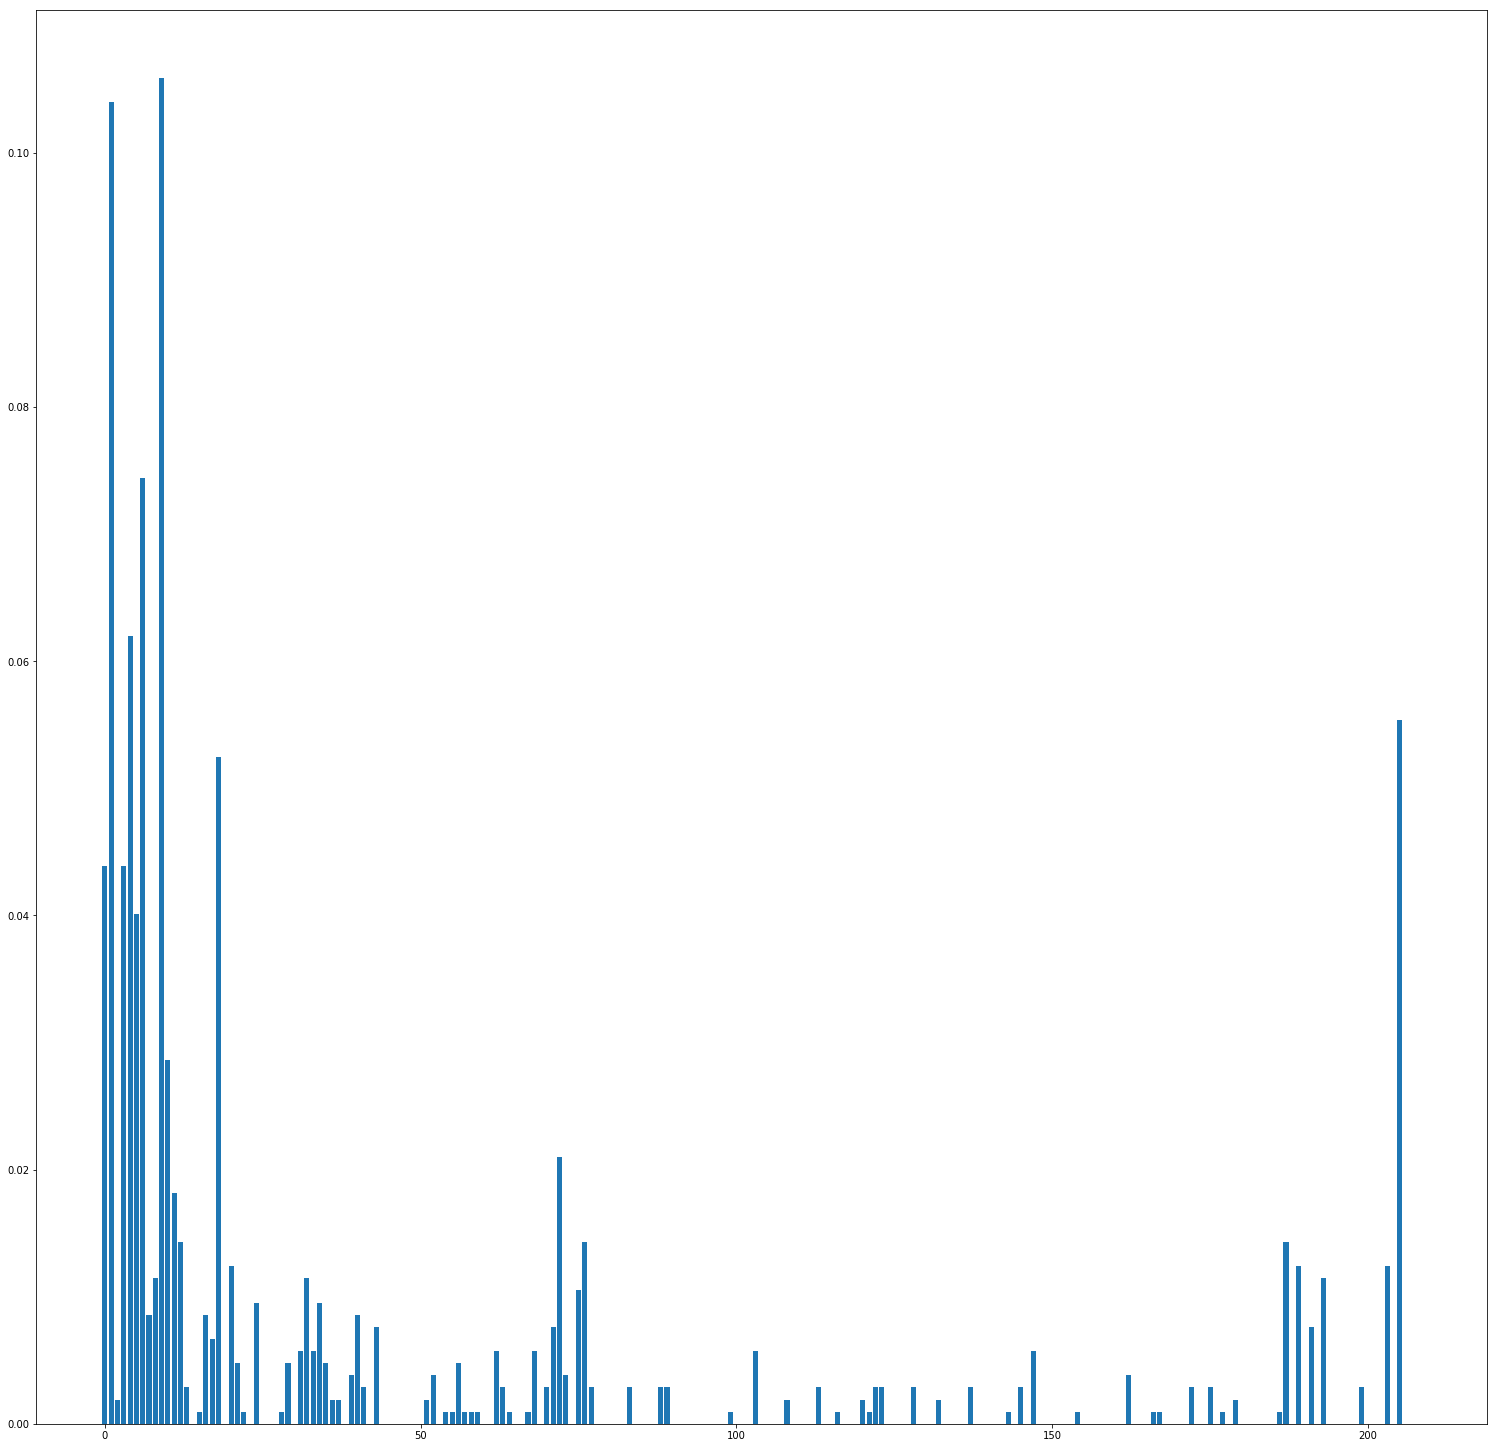

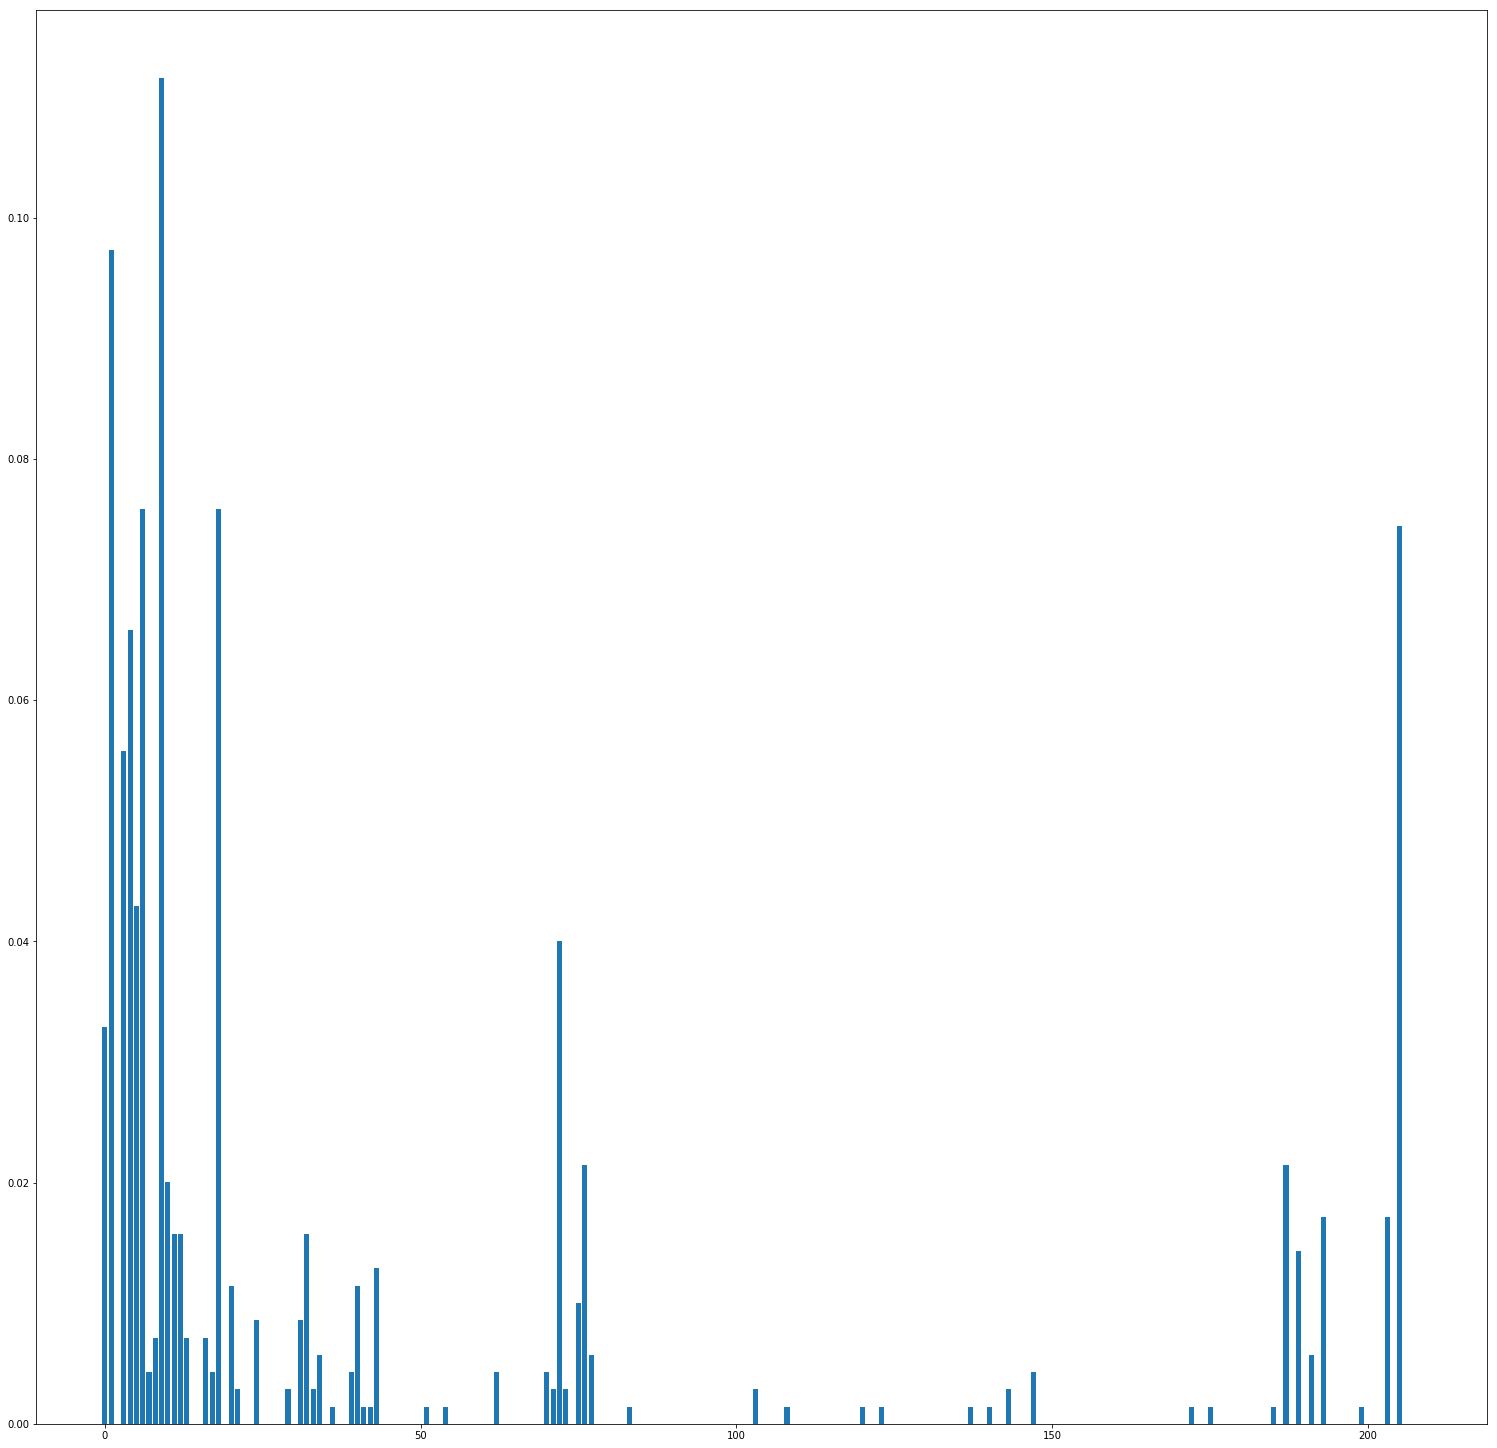

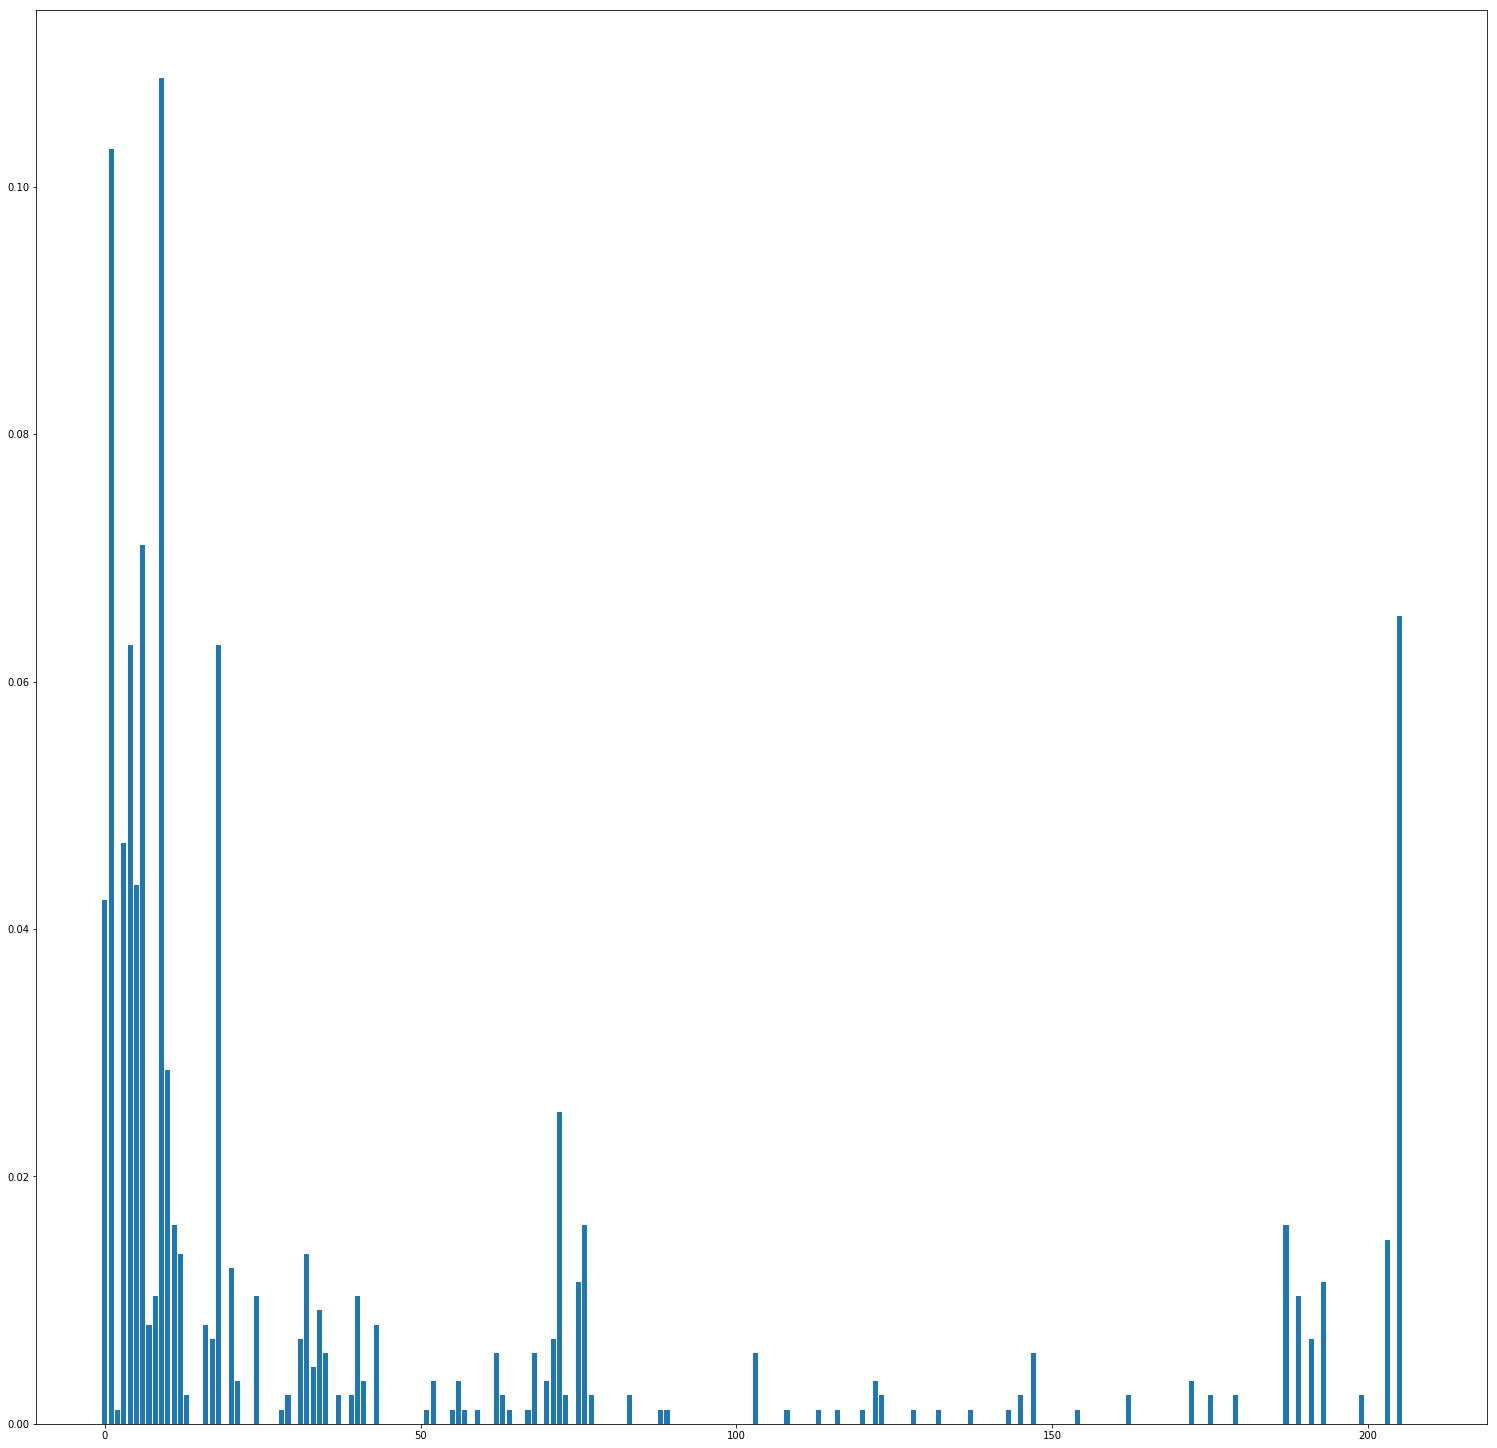

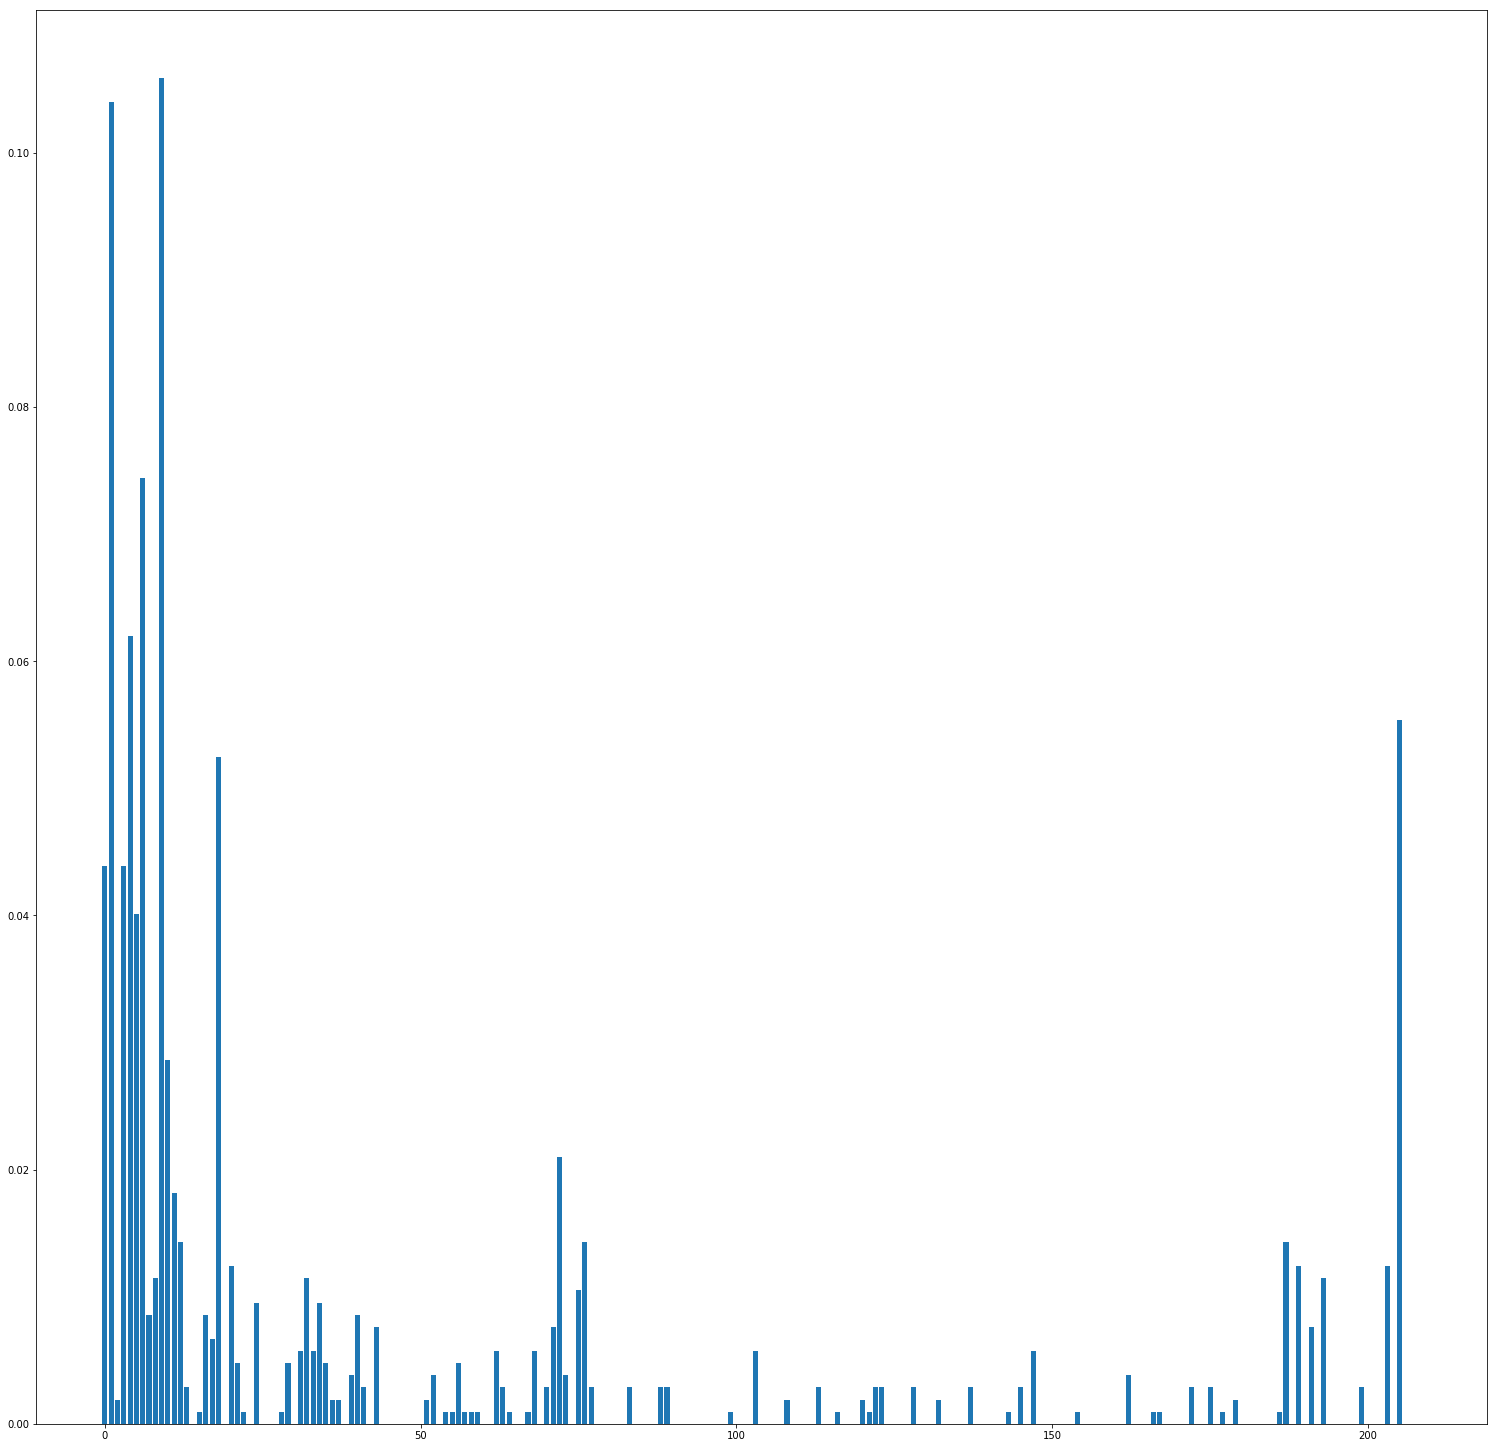

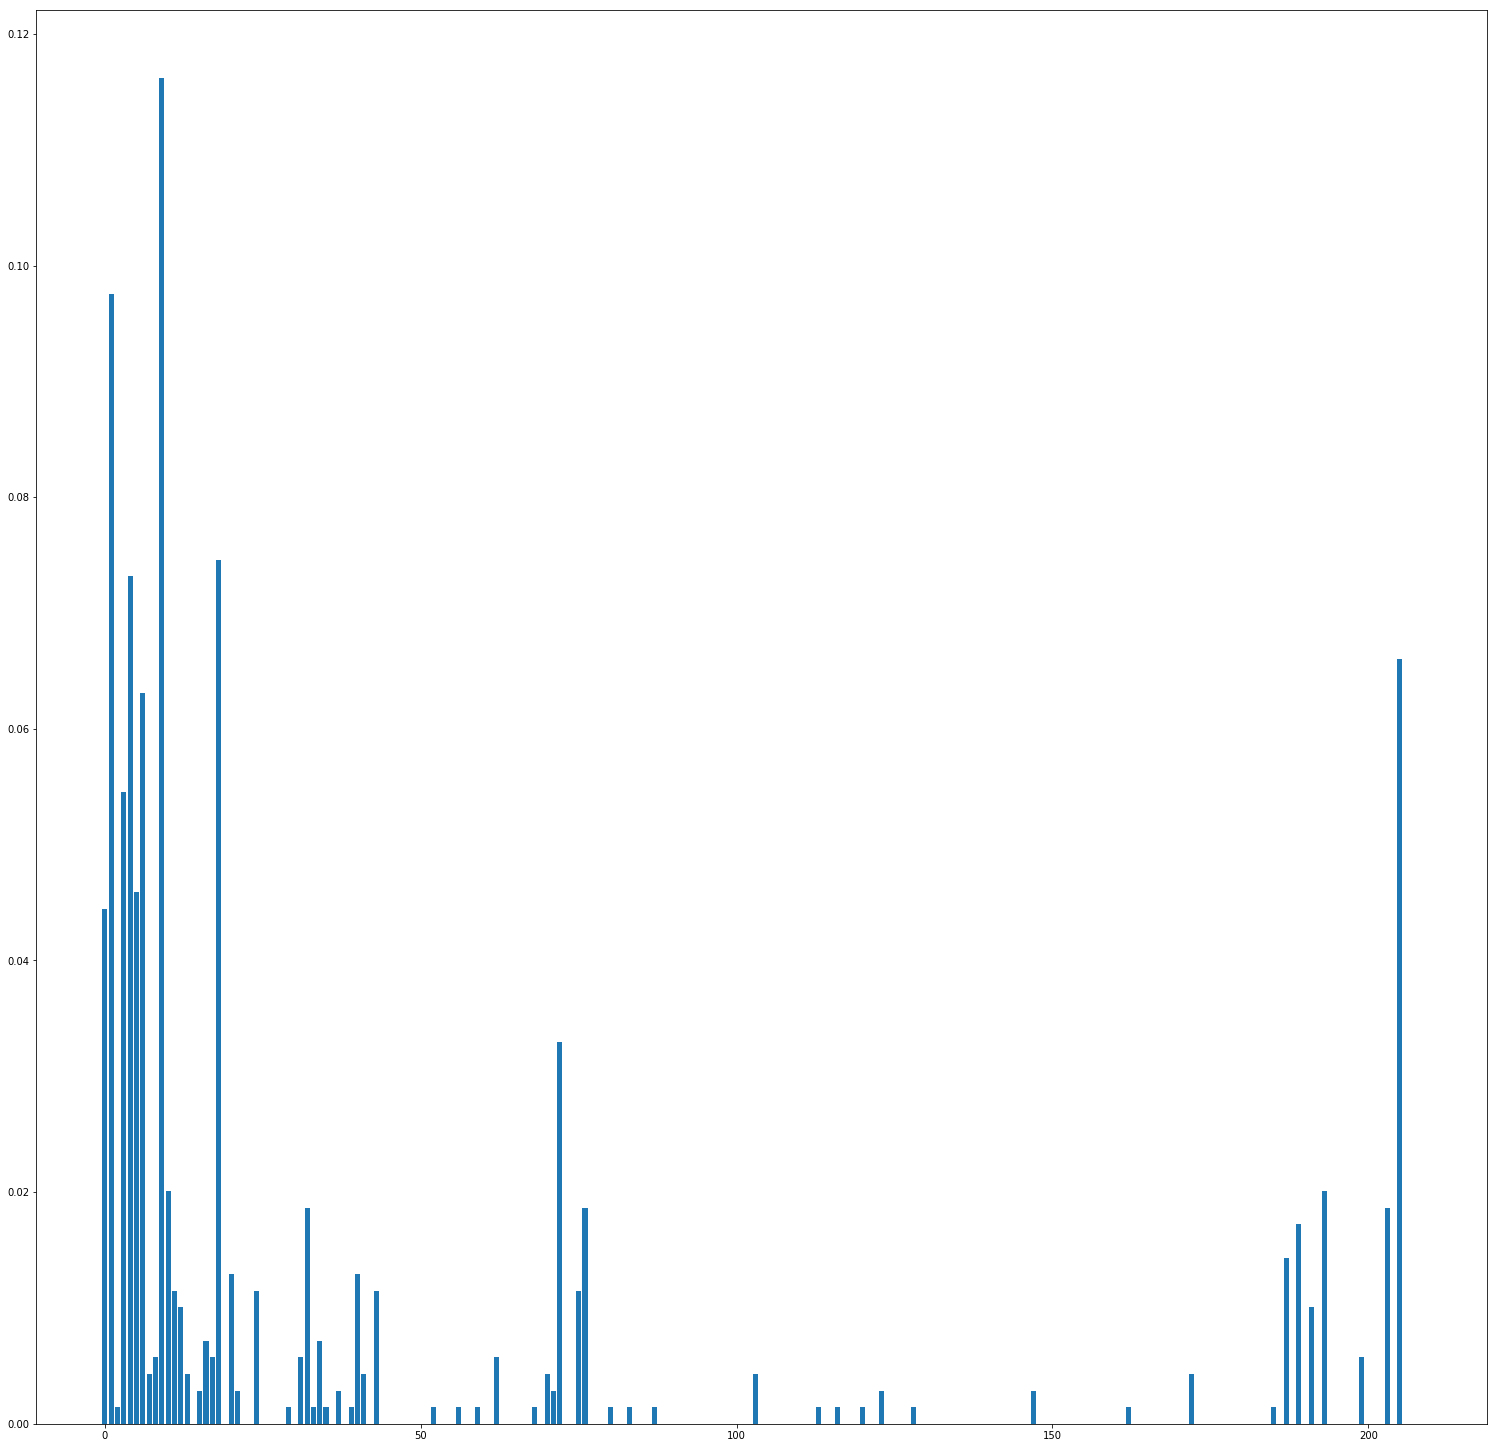

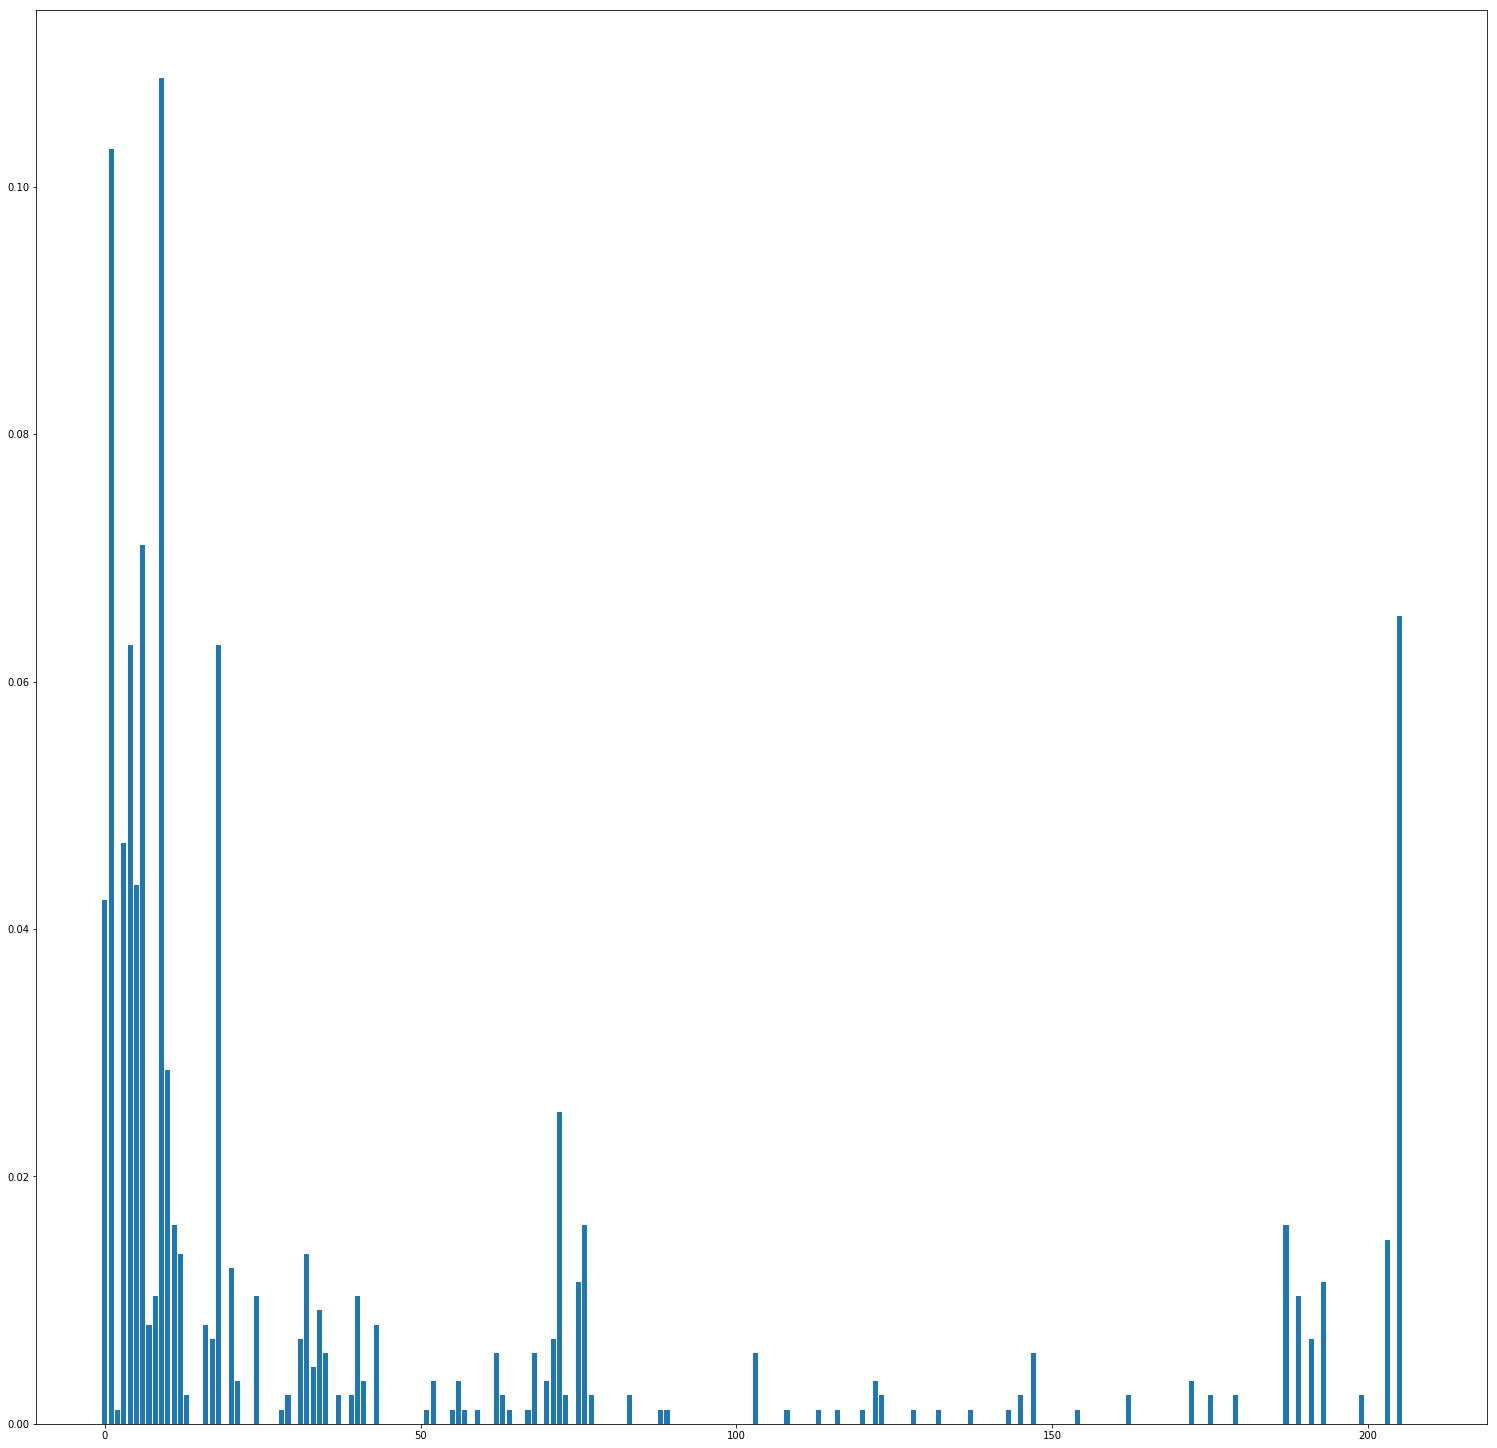

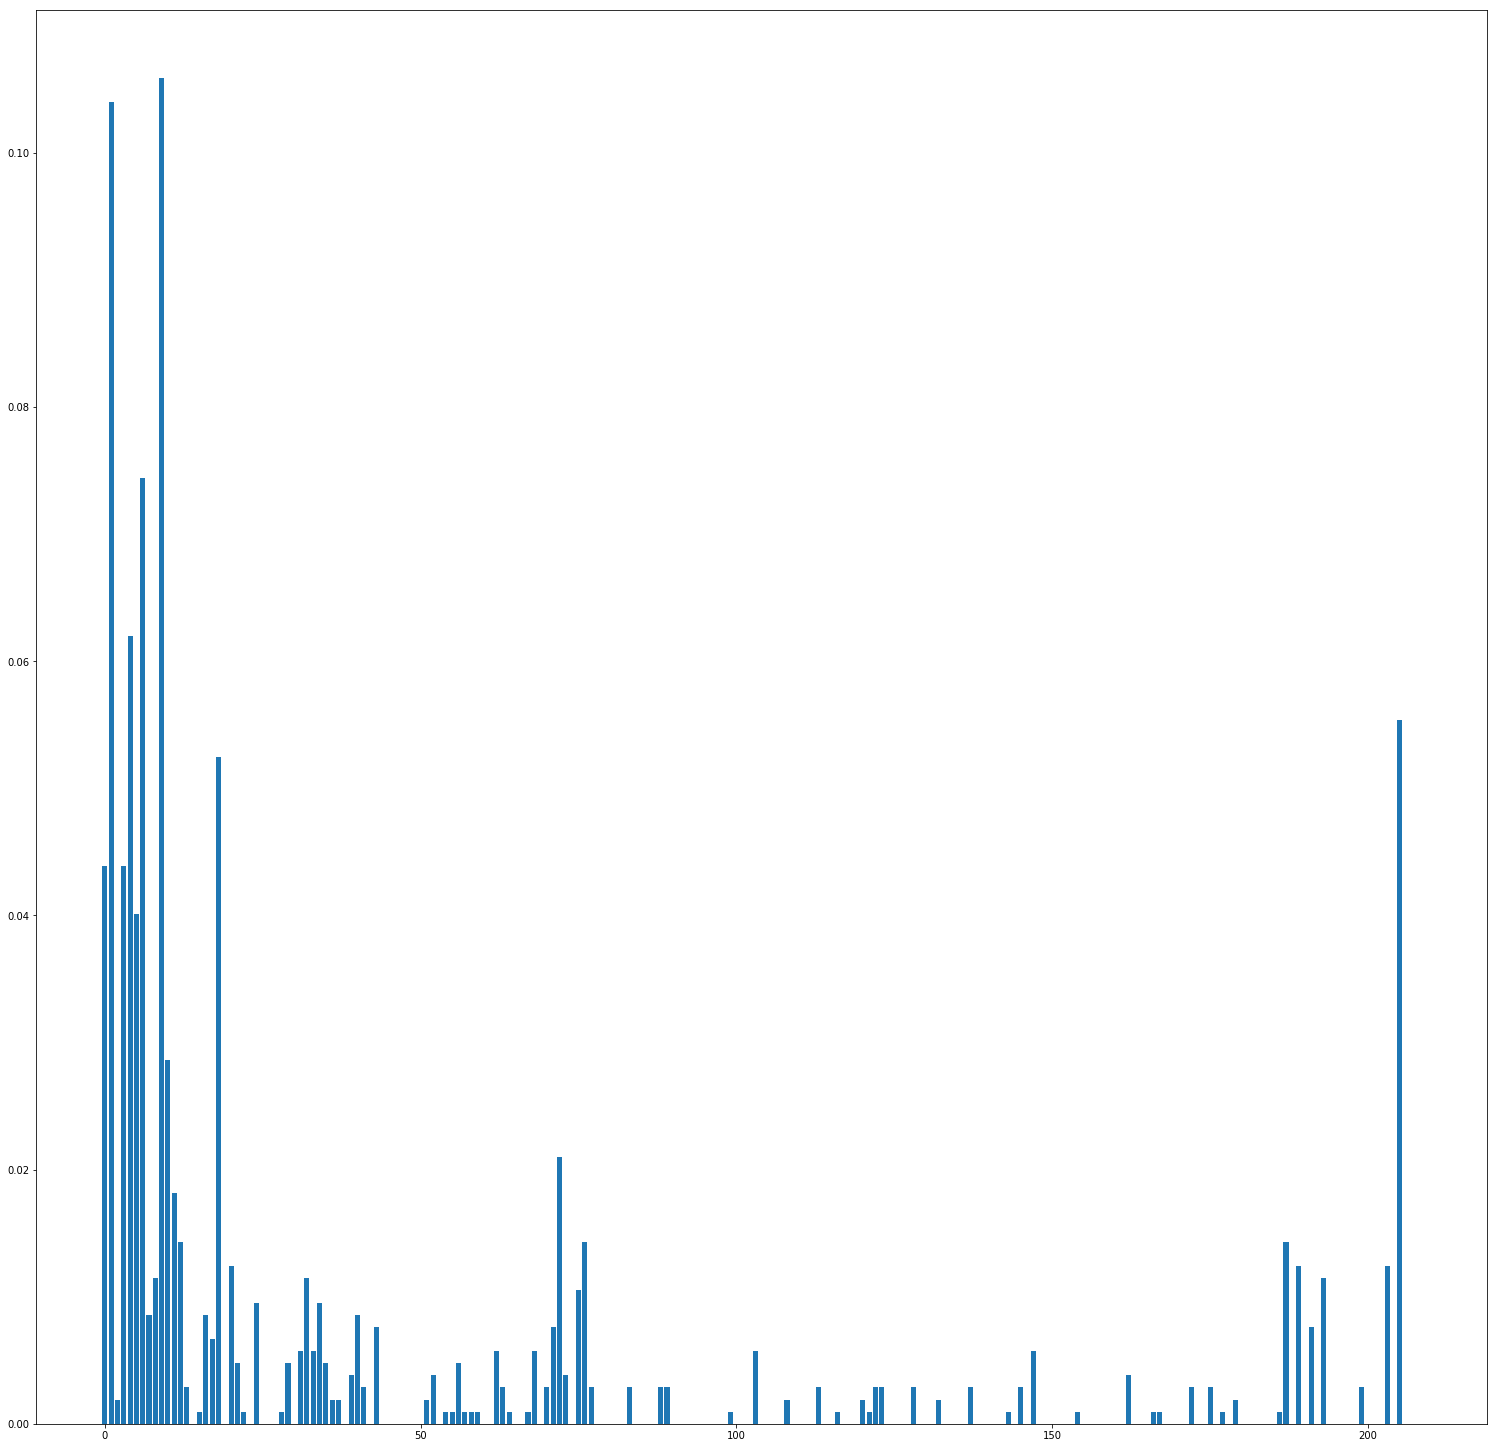

In [36]:
"""
Reference: Johannesss (2017) that implements stacking of LGBClassifiers in to logistic regression. 
Source: https://www.kaggle.com/johannesss/stacking-lightgbm-with-logisticregression  
Following this implementation, I implemented stacking XGBClassifiers (instead of LGBClassifiers) in to
logistic regression. 
"""
for i, (fit_index, val_index) in enumerate(splitter.split(X_train, y_train)):
    X_fit = X_train.iloc[fit_index,:].copy()
    y_fit = y_train[fit_index]
    X_val = X_train.iloc[val_index,:].copy()
    y_val = y_train[val_index]

    model1.fit(X_fit, y_fit,eval_metric=gini_normalized) 
    print(model1.get_params(deep=True)) 
    fig = plt.figure(figsize=(26,26))
    plt.bar(range(len(model1.feature_importances_)),model1.feature_importances_) 
    # plt.show() 
    fig.savefig('feature_selection1.png')
    y_val_predprob1 = model1.predict_proba(X_val)[:,1]
    
    x_test_pred1   = model1.predict_proba(X_test)[:,1] 
    
    x_train_pred1  = model1.predict_proba(X_train)[:,1] 
    X_logreg_test[:, i * num_models]  = x_test_pred1
    X_logreg_train[:, i * num_models] = x_train_pred1
    
    model2.fit(X_train, y_train, eval_metric=gini_normalized)
    print(model2.get_params(deep=True)) 
    fig = plt.figure(figsize=(26,26))  
    plt.bar(range(len(model2.feature_importances_)),model2.feature_importances_) 
    # plt.show() 
    fig.savefig('feature_selection2.png')
    y_val_predprob2 = model2.predict_proba(X_val)[:,1]
    
    x_test_pred2   = model2.predict_proba(X_test)[:,1] 
    x_train_pred2  = model2.predict_proba(X_train)[:,1] 
    X_logreg_test[:, i * num_models + 1]  = x_test_pred2
    X_logreg_train[:, i * num_models + 1] = x_train_pred2
    
    model3.fit(X_train, y_train, eval_metric=gini_normalized)
    print(model3.get_params(deep=True)) 
    fig = plt.figure(figsize=(26,26))  
    plt.bar(range(len(model3.feature_importances_)),model3.feature_importances_) 
    # plt.show() 
    fig.savefig('feature_selection3.png')
    y_val_predprob3 = model3.predict_proba(X_val)[:,1]
    
    x_test_pred3   = model3.predict_proba(X_test)[:,1] 
    x_train_pred3  = model3.predict_proba(X_train)[:,1] 
    X_logreg_test[:, i * num_models + 2]  = x_test_pred3
    X_logreg_train[:, i * num_models + 2] = x_train_pred3
    
log_model = LogisticRegression() 

log_model.fit(X = X_logreg_train, y = y_train)
target_predict = log_model.predict_proba(X_logreg_test)[:,1] 

# Save output 
sample = pd.read_csv('data/sample_submission.csv',low_memory=False)  
sample.target = target_predict
sample.to_csv("xgboost3_logistic.csv", float_format='%.6f',index=False) 

** 4. Results ** 

** 4.1 Model Evaluation and Validation ** 

** 4.2 Justification ** 

** 5. Conclusion ** 

** 5.1 Free-Form Visualization ** 

** 5.2 Reflection ** 

** 5.3 Improvement ** 